In [1]:
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
import numpy as np
from scipy import sparse
from tqdm import tqdm

In [4]:
from p_tqdm import p_map, p_umap

In [5]:
!ls ../data/processed

APIs.csv	   A_tst.npz	     counts_tr.npz   P_reduced_tr.npz
A_reduced_tr.npz   B_reduced_tr.npz  counts_tst.npz  P_tr.npz
A_reduced_tst.npz  B_tr.npz	     meta_tr.csv     P_tst.npz
A_tr.npz	   B_tst.npz	     meta_tst.csv    walks


## Gensim

In [6]:
!ls ../data/processed/walks -al

total 105399
drwxr-xr-x 2 yuz530 root       10 May 16 01:12  .
drwxrwxrwx 3 yuz530 root       18 May 16 14:22  ..
-rw-r--r-- 1 yuz530 root 62182673 May 12 09:47 'node2vec_n=100_p=2_q=1_wl=60.cor'
-rw-r--r-- 1 yuz530 root  9323624 May 16 21:45 'node2vec_n=15_p=2_q=1_wl=60.cor'
-rw-r--r-- 1 yuz530 root  9677255 May 16 22:19 'node2vec_n=15_p=2_q=1_wl=60_test.cor'
-rw-r--r-- 1 yuz530 root  9317970 May 16 01:12 'node2vec_n=15_p=2_q=1_wl=60_test_cp.cor'
-rw-r--r-- 1 yuz530 root   621114 May 16 01:14 'node2vec_n=1_p=2_q=1_wl=60_test.cor'
-rw-r--r-- 1 yuz530 root 62204045 May 12 09:52 'node2vec_n=200_p=2_q=1_wl=30.cor'
-rw-r--r-- 1 yuz530 root 62164085 May 12 09:53 'node2vec_n=20_p=2_q=1_wl=300.cor'
-rw-r--r-- 1 yuz530 root        0 May 12 19:08 'node2vec_n=30_p=2_q=1_wl=60.cor'


In [7]:
CORPUS = '../data/processed/walks/node2vec_n=15_p=2_q=1_wl=60.cor'

In [8]:
CORPUS_TEST = '../data/processed/walks/node2vec_n=15_p=2_q=1_wl=60_test.cor'

In [9]:
# f = open(CORPUS_TEST).readlines()

# walks = []
# for line in f:
#     walk = line.strip().split(' ')
#     walks.append([
#         f"app_{int(node.split('_')[-1]) + 1335}"
#         if node.startswith('app') else node
#         for node in walk
#     ])

In [10]:
# !cp ../data/processed/walks/node2vec_n=15_p=2_q=1_wl=60_test.cor

In [11]:
from gensim import utils

class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""
    def __init__(self, corpus_path):
        self.lines = open(CORPUS).readlines()
        self.lines += open(CORPUS_TEST).readlines()  # !!! Test

    def __iter__(self):
        corpus_path = CORPUS
        for line in tqdm(self.lines):
            # assume there's one document per line, tokens separated by whitespace
            yield line.strip().split(' ')

unable to import 'smart_open.gcs', disabling that module


In [12]:
sentences = MyCorpus(CORPUS)

In [13]:
import gensim.models

In [14]:
%%time
model = gensim.models.Word2Vec(
    sentences=sentences, size=64, sg=1, 
    negative=5, window=3, iter=5, min_count=1
)

100%|██████████| 40050/40050 [00:05<00:00, 6917.20it/s]


CPU times: user 1min 34s, sys: 429 ms, total: 1min 35s
Wall time: 33.2 s


In [15]:
meta_tr = pd.read_csv('../data/processed/meta_tr.csv', index_col=0)

In [16]:
meta_tst = pd.read_csv('../data/processed/meta_tst.csv', index_col=0)

In [17]:
meta_tr.head()

,label,package,csv_path
app_0,class1,157517784ed9b575846864aa3f39b3d7,data/interim/class1/157517784ed9b575846864aa3f...
app_1,class0,com.app.kilani_jobs,data/interim/class0/com.app.kilani_jobs.csv
app_2,class0,com.andromo.dev513556.app479954,data/interim/class0/com.andromo.dev513556.app4...
app_3,class1,b1cbf04952bc232b6484bccf0bbf7d36,data/interim/class1/b1cbf04952bc232b6484bccf0b...
app_4,class0,com.easyemerge.emergeeverywhere.android,data/interim/class0/com.easyemerge.emergeevery...


In [18]:
y_train = meta_tr.label == 'class1'

In [19]:
y_test = meta_tst.label == 'class1'

In [20]:
app_vec = np.array([model.wv[f'app_{i}'] for i in range(len(meta_tr))])

In [21]:
app_vec_tst = np.array([model.wv[f'app_{i}'] for i in range(len(meta_tr), len(meta_tr) + len(meta_tst))])

In [22]:
app_vec.shape

(1335, 64)

In [56]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=10, gamma=0.1)

In [57]:
svm.fit(app_vec, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [58]:
svm.score(app_vec, y_train)

0.9992509363295881

In [59]:
svm.score(app_vec_tst, y_test)

0.9835205992509364

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

In [50]:
param_grid = {
    "rgs__C": [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    "rgs__gamma": [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
}
p = Pipeline(steps=[
    ('rgs', SVC(kernel='rbf'))
])

In [51]:
gs = GridSearchCV(p, param_grid=param_grid, cv=4, return_train_score=True, iid=False, n_jobs=-1)

In [55]:
gs.fit(app_vec, y_train).best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'rgs__C': 10.0, 'rgs__gamma': 0.1}

In [20]:
!head ../data/processed/meta_tr.csv

,label,package,csv_path,AA,APA,ABA,APBPA,ABPBA
app_0,class1,157517784ed9b575846864aa3f39b3d7,data/interim/class1/157517784ed9b575846864aa3f39b3d7.csv,1,1,1,1,1
app_1,class0,com.app.kilani_jobs,data/interim/class0/com.app.kilani_jobs.csv,0,0,0,0,0
app_2,class0,com.andromo.dev513556.app479954,data/interim/class0/com.andromo.dev513556.app479954.csv,0,0,0,0,0
app_3,class1,b1cbf04952bc232b6484bccf0bbf7d36,data/interim/class1/b1cbf04952bc232b6484bccf0bbf7d36.csv,1,1,1,1,1
app_4,class0,com.easyemerge.emergeeverywhere.android,data/interim/class0/com.easyemerge.emergeeverywhere.android.csv,0,0,0,0,0
app_5,class0,io.westviewapp.official,data/interim/class0/io.westviewapp.official.csv,0,0,0,0,0
app_6,class0,com.conduit.app_f1cce681dece40e88f48fab0345c8f8c.app,data/interim/class0/com.conduit.app_f1cce681dece40e88f48fab0345c8f8c.app.csv,0,0,0,1,0
app_7,class0,com.sparrowworld.gujaratinglish,data/interim/class0/com.sparrowworld.gujaratinglish.csv,0,0,0,0,0
app_8,class1,509436e0d4fb98a6ef646a70019337

In [21]:
!ls ../data/processed/

APIs.csv	   A_tr.npz	     B_tr.npz	     meta_tr.csv       P_tr.npz
A_reduced_tr.npz   A_tst.npz	     counts_tr.npz   meta_tst.csv      walks
A_reduced_tst.npz  B_reduced_tr.npz  counts_tst.npz  P_reduced_tr.npz


In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    embs = {}

    for word in model.wv.vocab:
        if 'api' in word: continue
        embs[word] = model.wv[word]
    
    tsne_model = TSNE(n_components=2, random_state=0)
    new_values = tsne_model.fit_transform(list(embs.values()))

    token_coor = dict(zip(embs.keys(), new_values))

    plt.figure(figsize=(16, 12))
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for token, coor in token_coor.items():
        x, y = coor
        label = meta_tr[meta_tr.app_id == token].label.item()
        color = cycle[0] if label == 'class1' else cycle[1]
        plt.scatter(x, y, c=color, alpha=0.8)
# #         plt.annotate(labels[i],
# #                      xy=(x[i], y[i]),
# #                      xytext=(5, 2),
# #                      textcoords='offset points',
# #                      ha='right',
# #                      va='bottom')
    plt.show()

In [24]:
meta_tr['app_id'] = [f'app_{i}' for i in range(meta_tr.shape[0])]

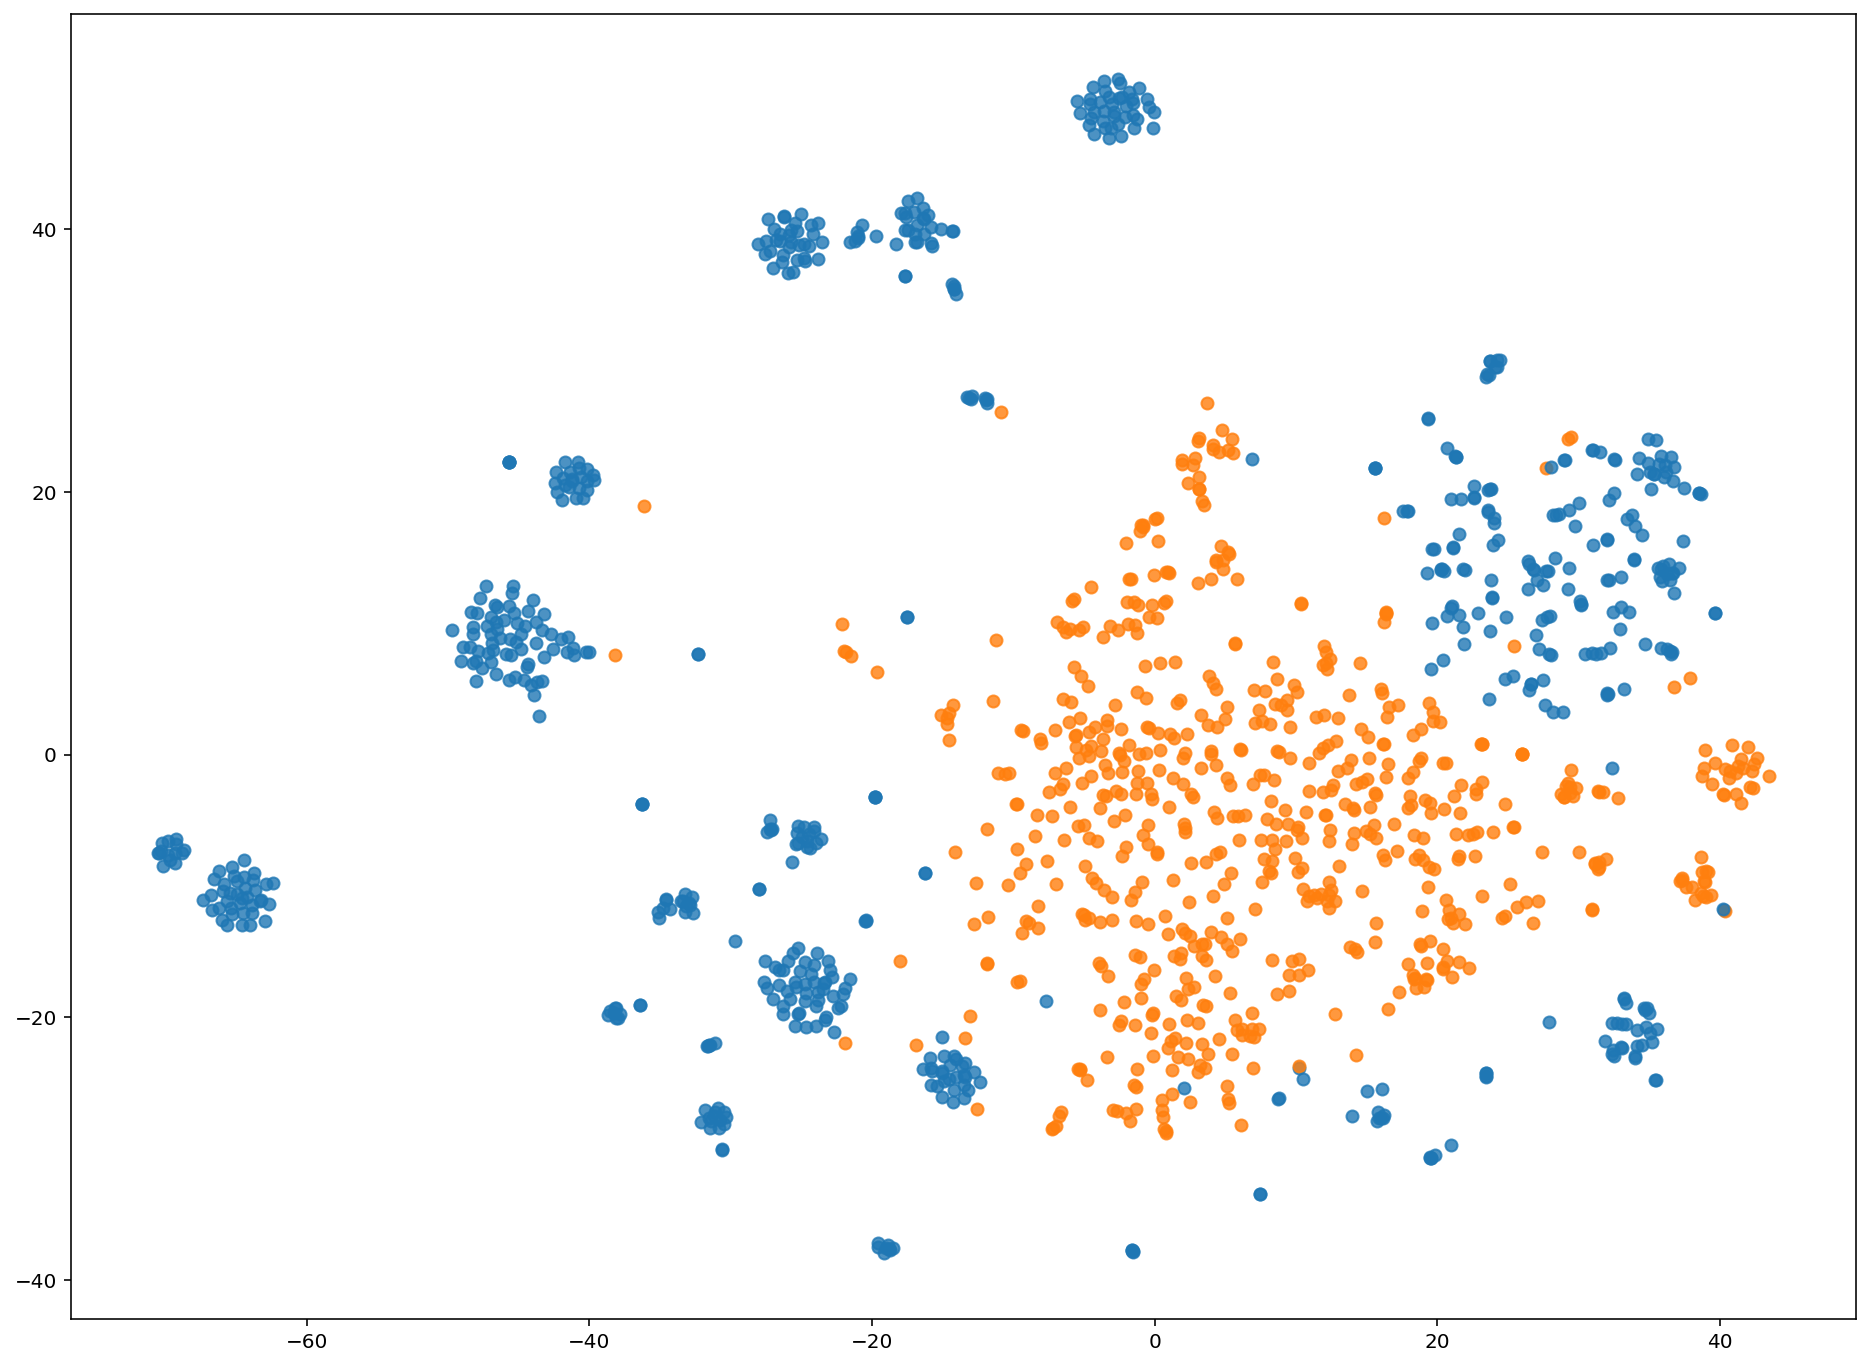

In [25]:
tsne_plot(model)

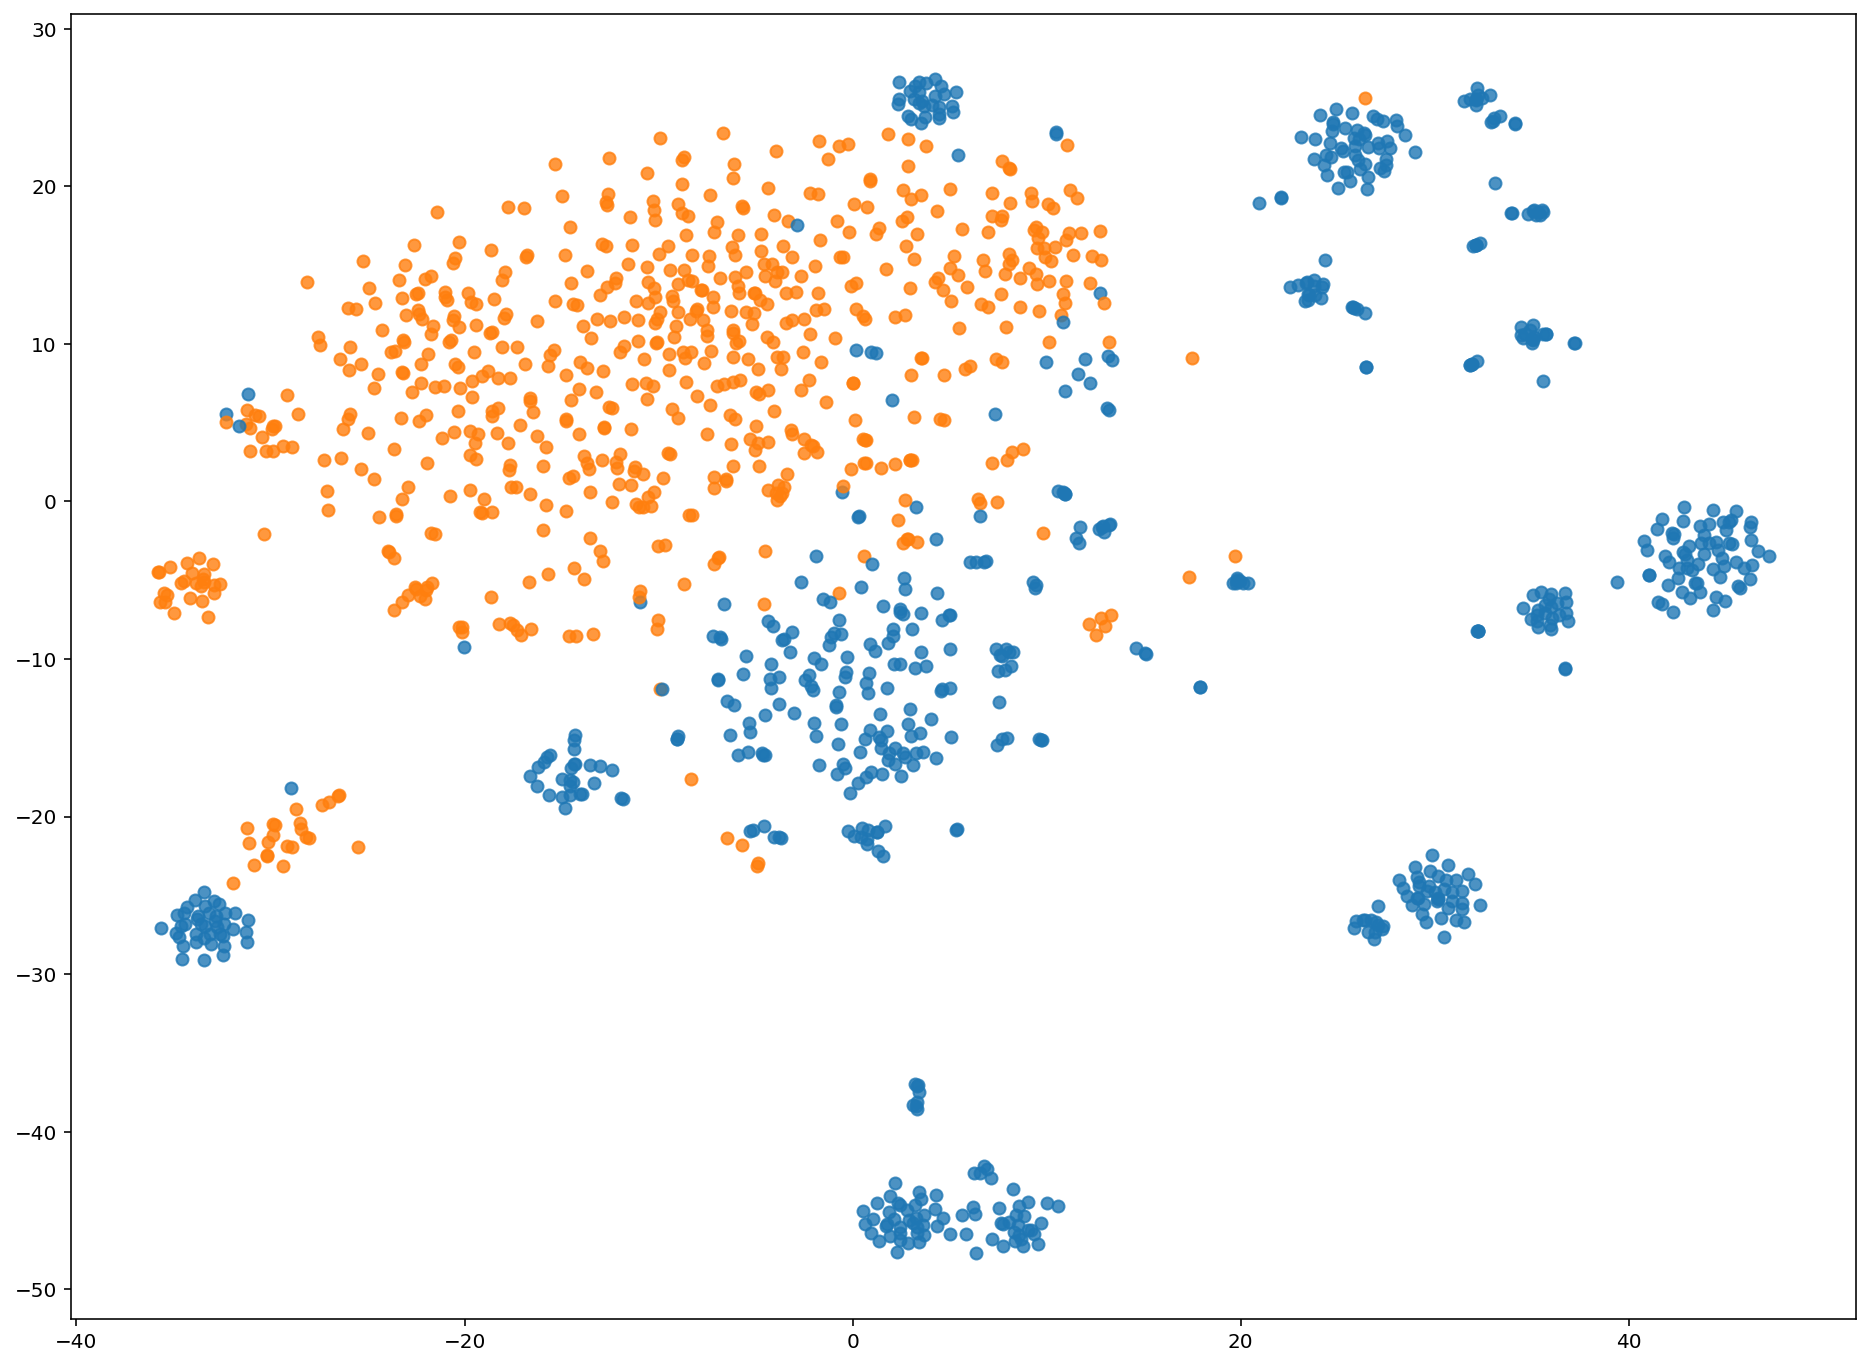

In [176]:
tsne_plot(model)

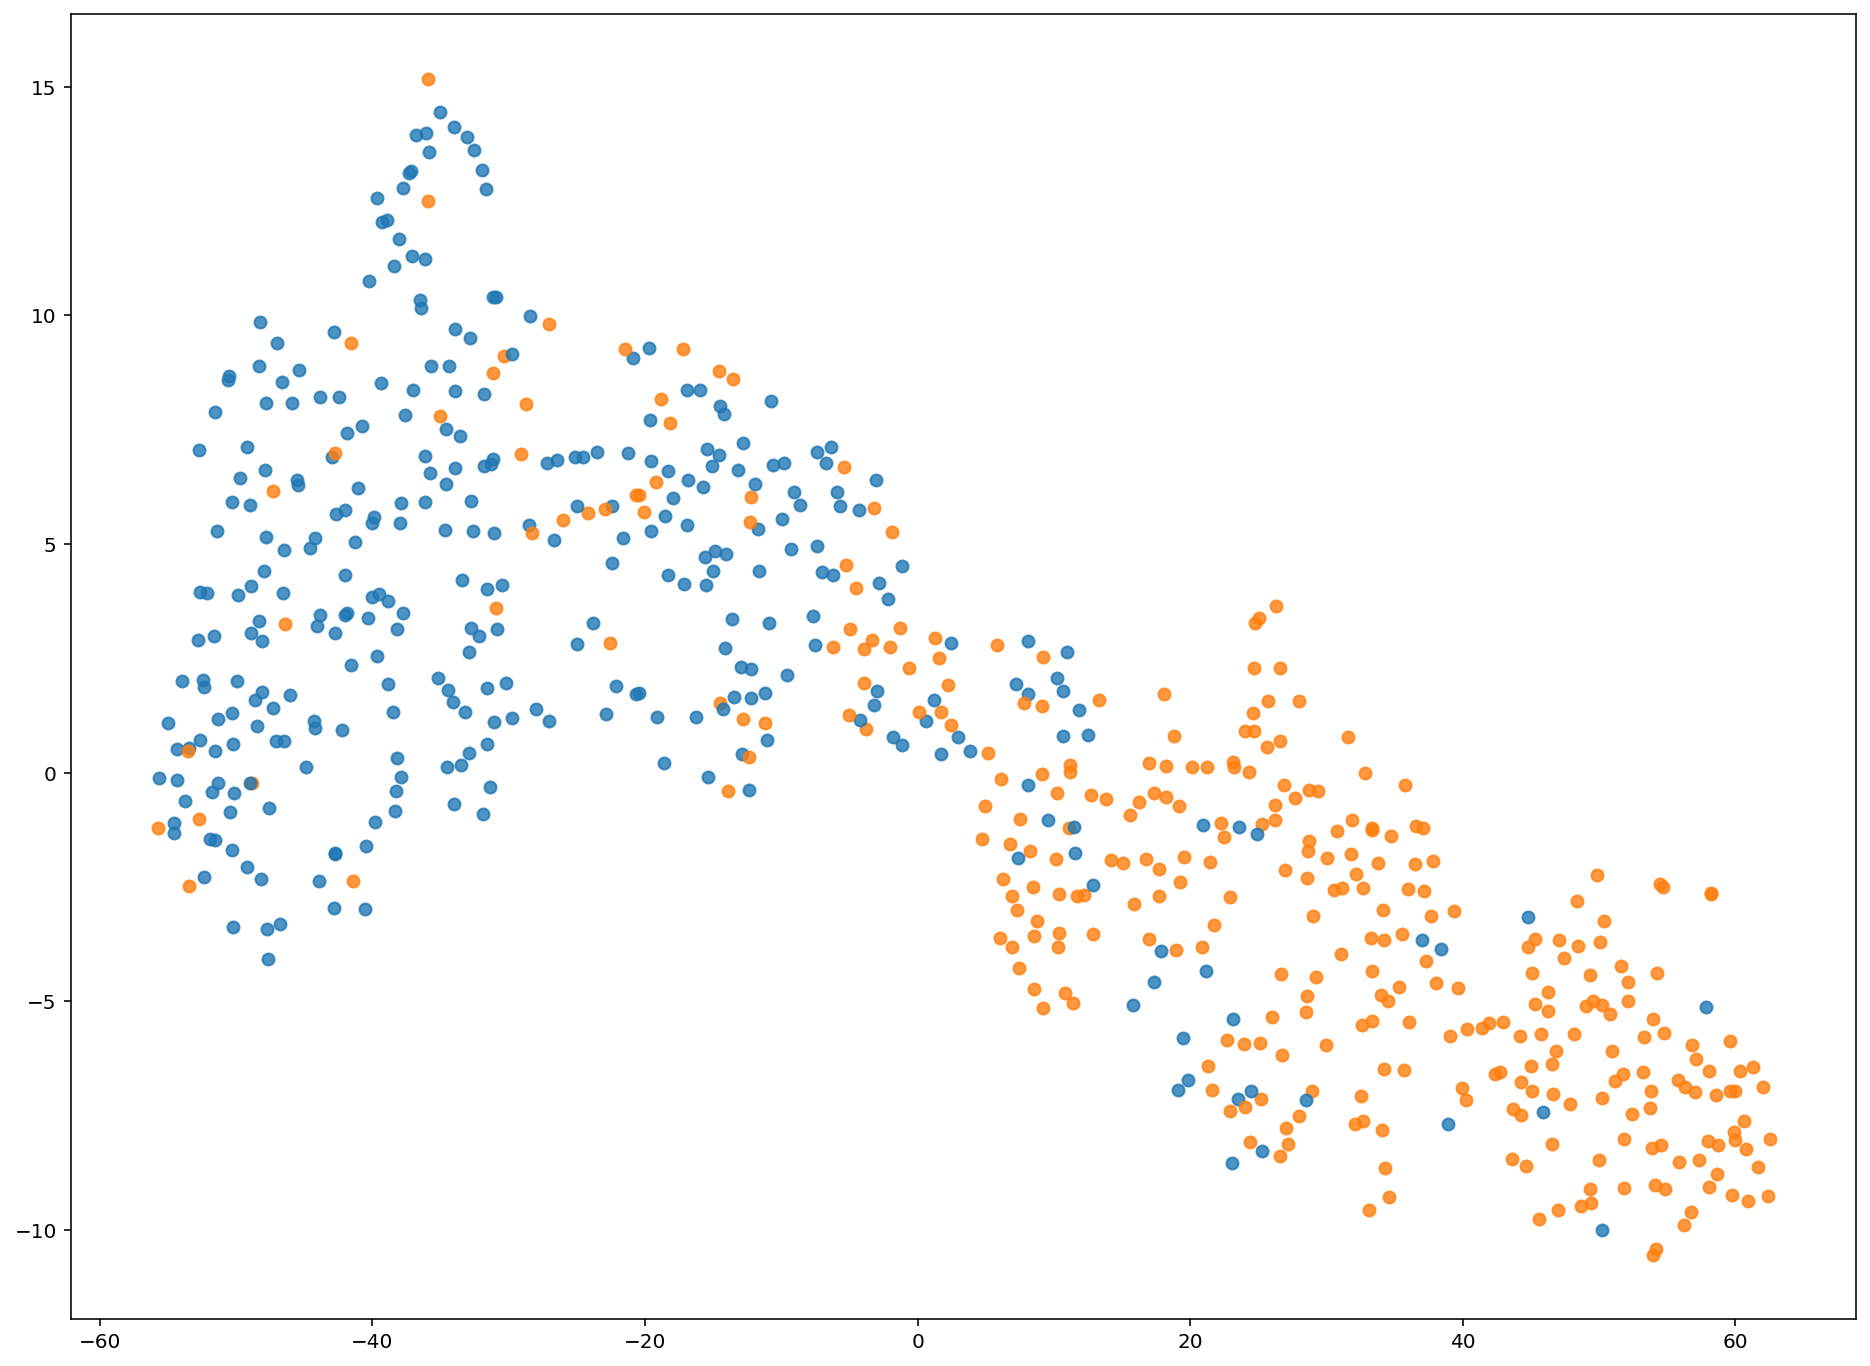

In [29]:
tsne_plot(model)
# node2vec_n=10_p=2_q=1_wl=100.cor

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
import os
proc_dir = '../data/processed'

counts_tr = sparse.load_npz(os.path.join(proc_dir, 'counts_tr.npz'))
counts_tst = sparse.load_npz(os.path.join(proc_dir, 'counts_tst.npz'))
df_tr = pd.read_csv(os.path.join(proc_dir, 'meta_tr.csv'), index_col=0)
df_tst = pd.read_csv(os.path.join(proc_dir, 'meta_tst.csv'), index_col=0)
malwares_tr = (df_tr.label == 'class1').values
malwares_tst = (df_tst.label == 'class1').values
apis = pd.read_csv(os.path.join(proc_dir, 'APIs.csv'))

In [28]:
import sys
sys.path.insert(0, '../')
from src.features.bm25.bm25 import BM25Transformer
bm = BM25Transformer()
bm_tr = bm.fit_transform(counts_tr)
bm_tst = bm.transform(counts_tst)

In [29]:
api_vec = np.array([model.wv[f'api_{i}'] for i in range(len(apis[apis.selected==True]))])

In [30]:
app_vec = np.array([model.wv[f'app_{i}'] for i in range(len(meta_tr))])

In [31]:
app_vec.shape, api_vec.shape

((1335, 64), (1000, 64))

In [37]:
api_vec = np.array([model.wv[f'api_{i}'] for i in range(len(apis[apis.selected==True]))])

app_vec = np.array([model.wv[f'app_{i}'] for i in range(len(meta_tr))])

app_vec.shape, api_vec.shape

np.save('api_emb', api_vec)
np.save('app_tr_emb', app_vec)

np.save('bm_tr', bm_tr[:, apis.selected.values].todense())
np.save('counts_tr', counts_tr[:, apis.selected.values].todense())

np.save('bm_tst', bm_tst[:, apis.selected.values].todense())
np.save('counts_tst', bm_tst[:, apis.selected.values].todense())